In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Loading data

In [2]:
base_NASA = Path("data/Software Defect Prediction - Data/dataNASA")
files_NASA = base_NASA.glob("*.csv")

# load file and remove id col
def load_one(path):
    return pd.read_csv(path, usecols=lambda c: c.lower() != "id")

# mapping name and data
NASA_data = {f.stem: load_one(f) for f in files_NASA}

# NASA_data["CM1"], NASA_data["KC3"], ...
print(NASA_data.keys())

NASA_data["CM1"].info()

dict_keys(['MW1', 'PC5', 'KC3', 'MC2', 'CM1', 'MC1', 'PC4', 'PC3', 'PC1', 'KC1'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   LOC_BLANK                        327 non-null    int64  
 1   BRANCH_COUNT                     327 non-null    int64  
 2   CALL_PAIRS                       327 non-null    int64  
 3   LOC_CODE_AND_COMMENT             327 non-null    int64  
 4   LOC_COMMENTS                     327 non-null    int64  
 5   CONDITION_COUNT                  327 non-null    int64  
 6   CYCLOMATIC_COMPLEXITY            327 non-null    int64  
 7   CYCLOMATIC_DENSITY               327 non-null    float64
 8   DECISION_COUNT                   327 non-null    int64  
 9   DECISION_DENSITY                 327 non-null    float64
 10  DESIGN_COMPLEXITY                327 non-null    int64  
 11  DE

### Imbalanced data

<Axes: xlabel='Defective'>

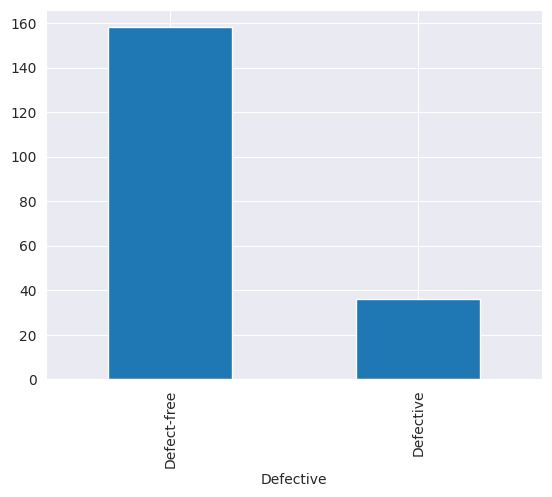

In [3]:
NASA_data["KC3"]["Defective"].value_counts().rename({'N':'Defect-free','Y':'Defective'}).plot(kind='bar')

In [17]:
datasets = ["CM1", "KC1", "KC3", "MC1", "MC2", "MW1", "PC1", "PC3", "PC4", "PC5"]

splits = {}

for name in datasets:
    y = np.where(NASA_data[name]["Defective"] == 'Y', 1, 0)
    X = NASA_data[name].drop(columns="Defective").to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

    splits[name] = {
        "train": (X_train, y_train),
        "test":  (X_test, y_test)
    }
    print(f'dataset: {name}, \n -shape of X: {X.shape}, \n -defect: {NASA_data[name]["Defective"].value_counts()}')
    print("------")


dataset: CM1, 
 -shape of X: (327, 37), 
 -defect: Defective
N    285
Y     42
Name: count, dtype: int64
------
dataset: KC1, 
 -shape of X: (1162, 21), 
 -defect: Defective
N    868
Y    294
Name: count, dtype: int64
------
dataset: KC3, 
 -shape of X: (194, 39), 
 -defect: Defective
N    158
Y     36
Name: count, dtype: int64
------
dataset: MC1, 
 -shape of X: (1952, 38), 
 -defect: Defective
N    1916
Y      36
Name: count, dtype: int64
------
dataset: MC2, 
 -shape of X: (124, 39), 
 -defect: Defective
N    80
Y    44
Name: count, dtype: int64
------
dataset: MW1, 
 -shape of X: (250, 37), 
 -defect: Defective
N    225
Y     25
Name: count, dtype: int64
------
dataset: PC1, 
 -shape of X: (679, 37), 
 -defect: Defective
N    624
Y     55
Name: count, dtype: int64
------
dataset: PC3, 
 -shape of X: (1053, 37), 
 -defect: Defective
N    923
Y    130
Name: count, dtype: int64
------
dataset: PC4, 
 -shape of X: (1270, 37), 
 -defect: Defective
N    1094
Y     176
Name: count, dtype:

## G-mean

In [5]:
from sklearn.metrics import confusion_matrix, make_scorer

def G_mean(cm):
    TN, FP, FN, TP = cm.ravel()
    sensitivity = TP / (TP + FN)
    specificity = 1 - FP / (TN + FN)

    return np.sqrt(sensitivity * specificity)

def Gmean_score_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return G_mean(cm)

gmean = make_scorer(Gmean_score_labels, greater_is_better=True)

### Greedy forward selection (GFS)
 * Sau khi khảo sát GFS với các dataset thì cho thấy hiệu quả đa số là giảm, vì vậy để cải thiện thì GFS sẽ có thêm 1 tham số là patient, tức là độ kiên nhẫn, từ đó cho phép chọn nhiều Feature hơn (thay vì AUC ko cải thiện thì giảm, hàm GFS bây giờ cho phép kiên nhẫn chờ đợi nếu hiệu quả thấp hơn patient lần thì dừng)

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

def GFS(X, y, estimator, scoring='roc_auc', cv=10, patient=0):
    n_features = X.shape[1]

    if isinstance(cv, int):
        cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    remaining = list(range(n_features))
    selected = []
    best_score = -np.inf
    target_k = n_features
    des = 0

    while remaining and len(selected) < target_k:
        scores = []

        for j in remaining:
            idx = selected + [j]
            est = clone(estimator)
            s = cross_val_score(estimator=est, X= X[:, idx], y=y, scoring=scoring, cv=cv, n_jobs=-1).mean()
            scores.append((s, j))

        s_best, j_best = max(scores, key=lambda t : t[0]) #so sánh phần tử đầu tiên của tuple
        # print(f'Add feature {j_best}, score = {s_best}')

        if s_best <= best_score:
            des += 1
            if des >= patient:
                break
        else:
            des = 0

        selected.append(j_best)
        remaining.remove(j_best)
        best_score = max(best_score, s_best)

    return selected, best_score

### Average Probability Ensemble (APE)
 * Random forest (RF)
 * Gradient boosting
 * Stochastic gradient descent (SGD)
 * Logistic regression
 * Multinomial naive Bayes (MNB)
 * Bernoulli naive Bayes (BNB)
 * Regular and weighted support vector machines (W-SVMs)

In [18]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

def APE():
    rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced_subsample')
    # đánh trọng số cho từng class dựa vào data trong cây đó (mỗi cây có cách đánh trọng số khác nhau)
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    # thông thường độ sâu của 1 cây thường nhỏ, tránh overfitting
    sgd = CalibratedClassifierCV(
            estimator=SGDClassifier(loss='log_loss', max_iter=2000, class_weight='balanced', random_state=42),
            method='sigmoid', cv=3
        ) # chuyển về xác suất chuẩn cho phù hợp với tỉ lệ phân phối của defect trong thực tế
    lr = LogisticRegression(max_iter=3000, class_weight='balanced')
    mnb = MultinomialNB(alpha=0.1)
    bnb = BernoulliNB(alpha=0.1, binarize=None)
    wsvm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

    ape = VotingClassifier(
        estimators=[
            ('rf', rf),
            ('gb', gb),
            ('sgd', sgd),
            ('lr', lr),
            ('mnb', mnb),
            ('bnb', bnb),
            ('wsvm', wsvm)
        ],
        voting='soft',
        weights=None
    )

    return ape


## Training without feature selection and SMOTE-PENN

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score


def make_training_pipeline():
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('clf', APE())
    ]

    )
    return pipe



In [22]:
result = {}

In [23]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]

    # scaler = MinMaxScaler() #avoid negative value in MultinomialNB
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)
    #
    # ape = APE()
    # select, best = GFS(X_train, y_train, estimator=ape) #bị data leak khi fit transform và truyền GFS (data leak trong cv)
    #
    # ape.fit(X_train[:, select], y_train)
    # select, best = GFS(X_train, y_train, estimator=make_training_pipeline())

    ape = make_training_pipeline()
    ape.fit(X_train, y_train)

    y_proba = ape.predict_proba(X_test)[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name] = {
        'AUC': [],
        'G-mean': []
    }
    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    # print(f' * F1: {f1_score(y_test, y_pred)}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

Dataset: CM1
 * AUC: 0.7241379310344828
 * G-mean: 0.5
Dataset: KC1
 * AUC: 0.7302681992337164
 * G-mean: 0.51400148916535
Dataset: KC3
 * AUC: 0.984375
 * G-mean: 0.5
Dataset: MC1
 * AUC: 0.7291666666666667
 * G-mean: 0.0
Dataset: MC2
 * AUC: 0.5
 * G-mean: 0.4264014327112209
Dataset: MW1
 * AUC: 0.8695652173913043
 * G-mean: 0.0
Dataset: PC1
 * AUC: 0.7956989247311828
 * G-mean: 0.0
Dataset: PC3
 * AUC: 0.8552522746071134
 * G-mean: 0.276013463353987
Dataset: PC4
 * AUC: 0.9148827726809379
 * G-mean: 0.5749396103553447
Dataset: PC5
 * AUC: 0.7922510518934082
 * G-mean: 0.5552843664244348


## Training with Feature selection (AUC)

In [24]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]

    select, best = GFS(X_train, y_train, estimator=make_training_pipeline(), patient=3)

    ape = make_training_pipeline()
    ape.fit(X_train[:, select], y_train)

    y_proba = ape.predict_proba(X_test[:, select])[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    print(f'Selected feature: {select}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Dataset: CM1
Selected feature: [2, 4, 16, 3, 5, 27, 25]
 * AUC: 0.6724137931034483
 * G-mean: 0.0
Dataset: KC1
Selected feature: [18, 20, 16, 2, 4, 3, 7, 5, 1]
 * AUC: 0.725287356321839
 * G-mean: 0.408248290463863
Dataset: KC3
Selected feature: [3, 34, 22, 13]
 * AUC: 0.9453125
 * G-mean: 0.0
Dataset: MC1
Selected feature: [35, 36, 10, 28, 13, 31, 24, 9, 5, 27, 8, 16]
 * AUC: 0.6940104166666667
 * G-mean: 0.0
Dataset: MC2
Selected feature: [35, 22, 16, 4, 27, 13, 0, 26, 21, 9]
 * AUC: 0.525
 * G-mean: 0.5577733510227171
Dataset: MW1
Selected feature: [10, 17, 14, 3, 9, 19, 24]
 * AUC: 0.8260869565217391
 * G-mean: 0.0
Dataset: PC1
Selected feature: [17, 12, 3, 8, 6, 36, 4, 10, 22, 33]
 * AUC: 0.8387096774193549
 * G-mean: 0.0
Dataset: PC3
Selected feature: [0, 35, 16, 32, 13, 10, 22, 3, 2, 20, 9]
 * AUC: 0.8610421836228288
 * G-mean: 0.0
Dataset: PC4
Selected feature: [3, 6, 8, 4, 28, 10, 13, 0, 1, 5, 12, 26, 36, 2, 24, 20, 21, 30]
 * AUC: 0.9148827726809379
 * G-mean: 0.5749396103553

In [25]:
print(result["CM1"])

{'AUC': [0.7241379310344828, 0.6724137931034483], 'G-mean': [np.float64(0.5), np.float64(0.0)]}


## Training with Feature selection (G_mean)

In [26]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]


    select, best = GFS(X_train, y_train, estimator=make_training_pipeline(), scoring=gmean, patient=3)

    ape = make_training_pipeline()
    ape.fit(X_train[:, select], y_train)

    y_proba = ape.predict_proba(X_test[:, select])[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    print(f'Selected feature: {select}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

Dataset: CM1
Selected feature: [21, 4, 0]
 * AUC: 0.7931034482758621
 * G-mean: 0.0
Dataset: KC1
Selected feature: [19, 2, 9, 3, 0, 12, 1, 18, 13, 11, 20, 17, 16, 5, 14, 8, 10, 7, 6, 4, 15]
 * AUC: 0.732567049808429
 * G-mean: 0.51400148916535
Dataset: KC3
Selected feature: [3, 31, 4, 7]
 * AUC: 0.65625
 * G-mean: 0.0
Dataset: MC1
Selected feature: [0, 1, 2]
 * AUC: 0.767578125
 * G-mean: 0.0
Dataset: MC2
Selected feature: [12, 31, 36, 24, 15, 26, 28]
 * AUC: 0.475
 * G-mean: 0.4264014327112209
Dataset: MW1
Selected feature: [2, 8, 16, 13, 3]
 * AUC: 0.9130434782608696
 * G-mean: 0.0
Dataset: PC1
Selected feature: [4, 9, 34, 14, 36, 6, 1, 33, 22, 5]
 * AUC: 0.8709677419354839
 * G-mean: 0.0
Dataset: PC3
Selected feature: [0, 11, 22, 4, 16, 18, 15, 30, 34, 19, 20, 21, 28, 10]
 * AUC: 0.8420181968569065
 * G-mean: 0.0
Dataset: PC4
Selected feature: [3, 13, 33, 34, 9, 24, 36, 1, 4, 5, 26, 6, 20, 0, 19, 28, 23]
 * AUC: 0.9286442405708459
 * G-mean: 0.524863881081478
Dataset: PC5
Selected f

## SMOTE-PENN

### Manual Implement

In [20]:
from sklearn.neighbors import NearestNeighbors

def smote_penn(X, y, k = 6, M = 0.5, N = 0.5):
    rand = np.random.RandomState(42)

    Smin = X[y==1]  # minority -> defective
    Smaj = X[y==0]  # majority
    Snewmin = Smin.copy()
    Snewmaj = np.array([])
    n_min, n_features = Smin.shape
    n_maj = Smaj.shape[0]
    L = max(1, int(np.floor(n_maj / n_min)))

    nn = NearestNeighbors(n_neighbors=k + 1, metric='euclidean') #hàm coi chính điểm đó là 1 neighbor
    nn.fit(X)

    #over-sample Spare point -> SMOTE
    for l in range(L):
        for xi in Smin:
            nn_idx = nn.kneighbors([xi], return_distance=False)[0][1:]  # bỏ chính nó
            neighbors = X[nn_idx]
            neighbors_label = y[nn_idx]

            #get defective NN
            NN_min_idx = nn_idx[neighbors_label == 1]

            if (NN_min_idx.size > 0) and (NN_min_idx.size / nn_idx.size < M):
                e_idx = rand.choice(NN_min_idx)
                ei = X[e_idx]
                alpha = rand.rand()
                x_new = xi + alpha*(ei - xi)
                Snewmin = np.vstack([Snewmin, x_new])

    #under-sample Dense point -> PENN

    # Tính NN trên tập đã cập nhật (thiểu số mới + đa số cũ)
    X_mix = np.vstack([Snewmin, Smaj])
    y_mix = np.hstack([np.ones(len(Snewmin), dtype=int),
                       np.zeros(len(Smaj), dtype=int)])

    nn_mix = NearestNeighbors(n_neighbors=k + 1, metric='euclidean')
    nn_mix.fit(X_mix)

    for yi in Smaj:
        nn_idx = nn.kneighbors([yi], return_distance=False)[0][1:]
        neighbors = X_mix[nn_idx]
        neighbors_label = y_mix[nn_idx]

        NN_maj_idx = nn_idx[neighbors_label == 0]
        if (NN_maj_idx.size / len(neighbors) >= N):
            Snewmaj.append(yi)

    # ghép lại tập balanced
    X_balanced = np.vstack([Snewmaj, Snewmin])
    y_balanced = np.hstack([np.zeros(len(Snewmaj)), np.ones(len(Snewmin))])
    return X_balanced, y_balanced


### Implement using library ImbLearn

In [15]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours


def make_training_pipeline_SMOTE_PENN():
    pipe = ImbPipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('smote', SMOTE(random_state=42)),
        ('enn',   EditedNearestNeighbours(n_neighbors=3)),
        ('clf', APE())
    ]

    )
    return pipe


In [16]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]

    # select, best = GFS(X_train, y_train, estimator=make_training_pipeline(), scoring=gmean)

    ape = make_training_pipeline_SMOTE_PENN()
    ape.fit(X_train, y_train)

    y_proba = ape.predict_proba(X_test)[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

KeyError: 'CM1'

## Ensample learning with SMOTE-PENN and Feature selection

### Scoring = AUC

In [20]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]

    select, best = GFS(X_train, y_train, estimator=make_training_pipeline())

    ape = make_training_pipeline_SMOTE_PENN()
    ape.fit(X_train[:, select], y_train)

    y_proba = ape.predict_proba(X_test[:, select])[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    print(f'Selected feature: {select}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

Dataset: CM1
Selected feature: [2, 4, 16, 3, 5]
 * AUC: 0.646551724137931
 * G-mean: 0.48304589153964794
Dataset: KC1
Selected feature: [18, 20, 16, 2, 4, 3, 7]
 * AUC: 0.7551724137931034
 * G-mean: 0.5718252591344029
Dataset: KC3
Selected feature: [3, 34]
 * AUC: 0.953125
 * G-mean: 0.5
Dataset: MC1
Selected feature: [35, 36, 10, 28, 13, 31, 24, 9, 5, 27]
 * AUC: 0.6432291666666666
 * G-mean: 0.4688577462374878
Dataset: MC2
Selected feature: [35, 22, 16, 4, 27, 13, 0, 26]
 * AUC: 0.5
 * G-mean: 0.4472135954999579
Dataset: MW1
Selected feature: [10, 17, 14, 3, 9]
 * AUC: 0.8695652173913043
 * G-mean: 0.0
Dataset: PC1
Selected feature: [17, 12, 3, 8, 6]
 * AUC: 0.8225806451612903
 * G-mean: 0.5360562674188974
Dataset: PC3
Selected feature: [0, 35, 16, 32, 13, 10, 22]
 * AUC: 0.8502894954507857
 * G-mean: 0.716114874039433
Dataset: PC4
Selected feature: [3, 6, 8, 4, 28, 10, 13]
 * AUC: 0.9240570846075433
 * G-mean: 0.7174822895944912
Dataset: PC5
Selected feature: [25, 19, 9, 32, 3, 2, 4

### Scoring = G-mean

In [21]:

for name in datasets:
    X_train, y_train = splits[name]["train"]
    X_test, y_test = splits[name]["test"]

    select, best = GFS(X_train, y_train, estimator=make_training_pipeline(), scoring=gmean)

    ape = make_training_pipeline_SMOTE_PENN()
    ape.fit(X_train[:, select], y_train)

    y_proba = ape.predict_proba(X_test[:, select])[:, 1]   #(defect-free, defective)
    y_pred = (y_proba >= 0.5).astype(int)

    auc_score = roc_auc_score(y_test, y_proba)
    gmean_score = G_mean(confusion_matrix(y_test, y_pred))

    result[name]['AUC'].append(auc_score)
    result[name]['G-mean'].append(gmean_score)

    print(f'Dataset: {name}')
    print(f'Selected feature: {select}')
    print(f' * AUC: {auc_score}')
    print(f' * G-mean: {gmean_score}')

Dataset: CM1
Selected feature: [21]
 * AUC: 0.646551724137931
 * G-mean: 0.5
Dataset: KC1
Selected feature: [19, 2, 9, 3]
 * AUC: 0.692528735632184
 * G-mean: 0.5370861555295746
Dataset: KC3
Selected feature: [3, 31]
 * AUC: 0.875
 * G-mean: 0.0
Dataset: MC1
Selected feature: [0]
 * AUC: 0.55078125
 * G-mean: 0.0
Dataset: MC2
Selected feature: [12, 31, 36, 24, 15]
 * AUC: 0.425
 * G-mean: 0.4264014327112209
Dataset: MW1
Selected feature: [2, 8, 16]
 * AUC: 0.9347826086956521
 * G-mean: 0.0
Dataset: PC1
Selected feature: [4, 9, 34, 14, 36, 6]
 * AUC: 0.8037634408602151
 * G-mean: 0.5477225575051661
Dataset: PC3
Selected feature: [0, 11, 22, 4, 16, 18, 15]
 * AUC: 0.8229942100909843
 * G-mean: 0.716114874039433
Dataset: PC4
Selected feature: [3, 13, 33, 34]
 * AUC: 0.8807339449541285
 * G-mean: 0.6244494430442219
Dataset: PC5
Selected feature: [1, 3, 34, 7, 4, 9, 17, 16, 2, 8, 12, 10]
 * AUC: 0.8062762973352033
 * G-mean: 0.7101745039685362


## Visualization

### AUC score

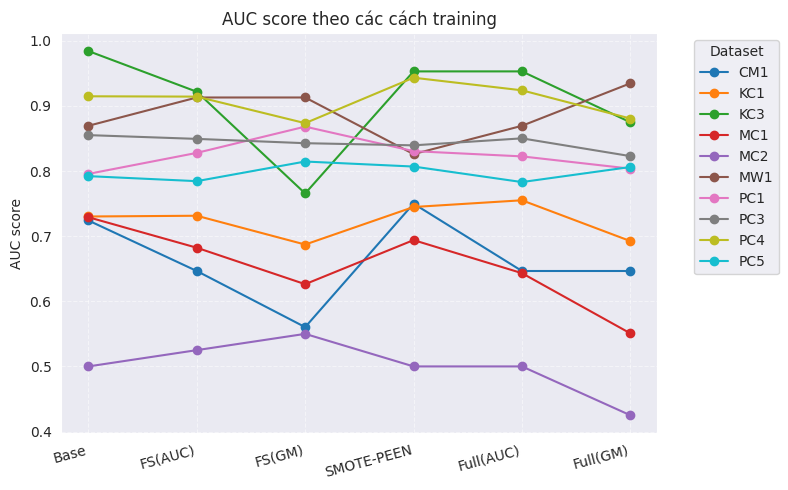

In [28]:
labels = ["Base", "FS(AUC)", "FS(GM)", "SMOTE-PEEN", "Full(AUC)", "Full(GM)"]
x = np.arange(len(labels))

plt.figure(figsize=(8,5))

for name in datasets:
    auc = result[name]["AUC"]
    plt.plot(x, auc, 'o-', label=name)  # mỗi dataset một đường

plt.xticks(x, labels, rotation=15, ha='right')
plt.ylabel("AUC score")
plt.title("AUC score theo các cách training")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')  # legend ra ngoài cho gọn
plt.tight_layout()
plt.show()

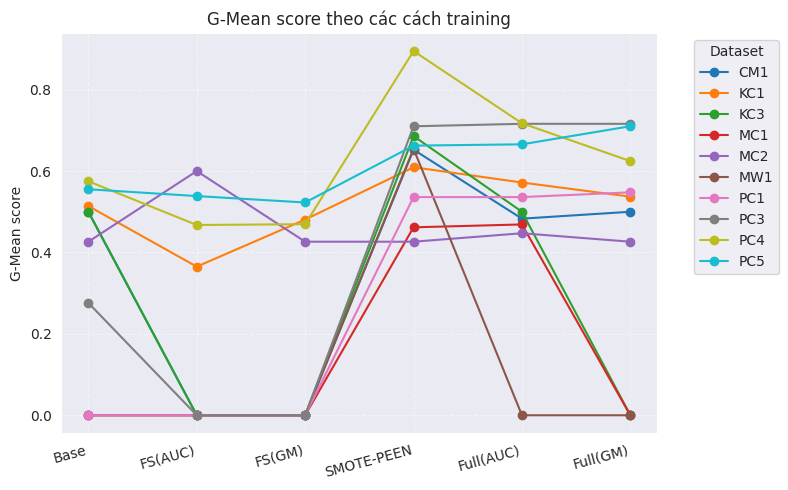

In [33]:
plt.figure(figsize=(8,5))

for name in datasets:
    auc = result[name]["G-mean"]
    plt.plot(x, auc, 'o-', label=name)  # mỗi dataset một đường

plt.xticks(x, labels, rotation=15, ha='right')
plt.ylabel("G-Mean score")
plt.title("G-Mean score theo các cách training")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')  # legend ra ngoài cho gọn
plt.tight_layout()
plt.show()